In [348]:
import os, sys, re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torchcde
import h5py
from scipy.signal import find_peaks
import MulensModel as mm
import corner
from model.utils import getfsfb
from matplotlib.offsetbox import AnchoredText

from scipy.signal import medfilt

from model.locator import Locator
from model.cde_mdn import CDE_MDN

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rc('font', size=14)

In [325]:
x_orig = np.loadtxt('./KMT/kb190371_aligned.csv', delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(x_orig[:, 0])
x_orig = x_orig[order]
err = x_orig[:, -1]
x_orig = x_orig[:, :-1]
x = x_orig
err = err[x[:, 0] > 8500]
x = x[x[:, 0] > 8500]
# err = err[x[:, 0] < 8650]
# x = x[x[:, 0] < 8650]

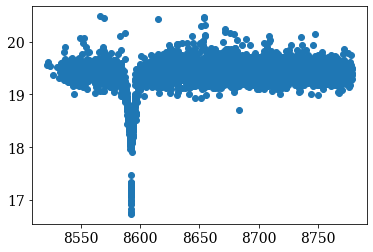

In [326]:
plt.scatter(x[:, 0], x[:, 1])
# plt.xlim(8590, 8595)

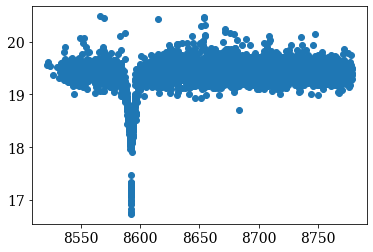

In [327]:
# x[:, 1] = medfilt(x[:, 1], 7)
# threshold = 0.1
# ind = err < threshold
# x = x[ind]
# err = err[ind]
plt.scatter(x[:, 0], x[:, 1])

In [328]:
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(torch.tensor(x).unsqueeze(0))

In [329]:
k = 2; method='avg'
checkpt = torch.load('/work/hmzhao/experiments/locator/experiment_smallte.ckpt', map_location='cpu')
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

model = Locator(device, k=k, method=method).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

Locator(
  (prefilter): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
    (1): PReLU(num_parameters=1)
    (2): Conv1d(16, 16, kernel_size=(15,), stride=(1,), padding=(7,), padding_mode=reflect)
    (3): PReLU(num_parameters=1)
    (4): Conv1d(16, 1, kernel_size=(1,), stride=(1,), padding_mode=reflect)
    (5): PReLU(num_parameters=1)
  )
  (unet): UNET_1D(
    (AvgPool1D1): AvgPool1d(kernel_size=(1,), stride=(5,), padding=(0,))
    (AvgPool1D2): AvgPool1d(kernel_size=(1,), stride=(25,), padding=(0,))
    (AvgPool1D3): AvgPool1d(kernel_size=(1,), stride=(125,), padding=(0,))
    (layer1): Sequential(
      (0): conbr_block(
        (conv1): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,))
        (bn): InstanceNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): PReLU(num_parameters=1)
      )
      (1): re_block(
        (cbr1): conbr_block(
          (conv1): Conv1d(128, 128, k

In [330]:
with torch.no_grad():
    model.eval()
    res = model(train_coeffs.float().to(device), torch.zeros((1, 2)).to(device))
    pred_t = res[0].detach().cpu().numpy()

In [333]:
pred_t

array([[8.595121e+03, 6.253970e+00]], dtype=float32)

In [420]:
# tel = pd.read_csv('./kb190371_aligned.csv', skiprows=0, usecols=[0, 2, 5, 6])
# tel = tel[(tel['Tel'] != 'KMTS01') & (tel['Tel'] != 'KMTS41')]
# x_orig = tel[['HJD', 'mag_aligned', 'e_mag_aligned']].to_numpy()
x_orig = np.loadtxt('./KMT/kb190371_aligned.csv', delimiter=',', skiprows=1, usecols=(2, 5, 6))
order = np.argsort(x_orig[:, 0])
x_orig = x_orig[order]
err = x_orig[:, -1]
x_orig = x_orig[:, :-1]
t0 = 8592.392; tE = 6.55
x_orig[:, 0] = (x_orig[:, 0] - t0)/tE
ind = (x_orig[:, 0] > -2) * (x_orig[:, 0] < 2)
mbase = x_orig[~ind, 1].mean()
x_orig = x_orig[ind]
err = err[ind]
# ind = (x_orig[:, 0] < -0.03) * (x_orig[:, 0] > -0.045)
# x_orig = x_orig[~ind]
# err = err[~ind]
x = x_orig

In [335]:
# x[:, 1] = medfilt(x[:, 1], 7)
x[:, 1] = medfilt(x[:, 1], 7)
# x[x[:, 0] < -0.1, 1] = medfilt(x[x[:, 0] < -0.1, 1], 5)
# x[x[:, 0] > 0.1, 1] = medfilt(x[x[:, 0] > 0.1, 1], 5)

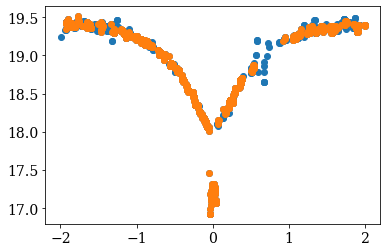

In [337]:
threshold = 0.06
plt.scatter(x[:, 0], x[:, 1])
plt.scatter(x[err<threshold, 0], x[err<threshold, 1])
# plt.xlim(-0.3, 0.3)
len(x[err<threshold, 0])
ind = err < threshold
x = x[ind]
err = err[ind]
x[:, 1] = (x[:, 1] - mbase) / 0.2

In [338]:
data = torch.tensor(x.reshape(1, *x.shape))
# depth = 3; window_length = 4
depth = 3; window_length = 8
data = torchcde.logsig_windows(data, depth, window_length=window_length)
train_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(data)

In [444]:
checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_l32nG12diag.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = 5
input_dim = data.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [445]:
with torch.no_grad():
    pi, normal = model(train_coeffs.float().to(device))

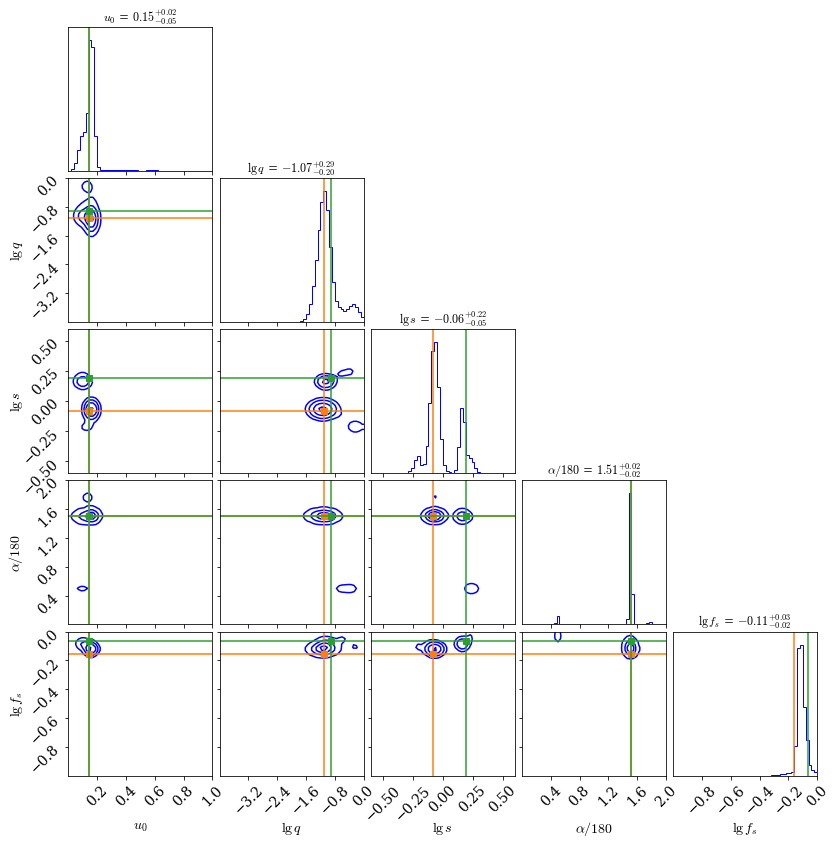

In [358]:
n = int(1e6)

pi_ = pi.probs.cpu(); loc_ = normal.loc.cpu(); scale_ = normal.scale.cpu()
pi_ = torch.tile(pi_, (n, 1)); loc_ = torch.tile(loc_, (n, 1, 1)); scale_ = torch.tile(scale_, (n, 1, 1))
normal_dist = torch.distributions.Normal(loc_, scale_)
pi_dist = torch.distributions.OneHotCategorical(probs=pi_)
sample = model.sample(pi_dist, normal_dist).numpy()


test_p = [[0.140, np.log10(6.46)-3, np.log10(0.079), np.log10(0.826), 2-1.542/np.pi, 0],
        [0.141, np.log10(6.99)-3, np.log10(0.123), np.log10(1.575), 2-1.544/np.pi, 0]]
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[0][:-1])[1:3]
test_p[0][-1] = np.log10(fs / (fs + fb))
fs, fb = getfsfb(x[:, 0], 10**(x[:, 1]/5/(-2.5)), err/(2.5*np.log(10))*10**(x[:, 1]/5/(-2.5)), 0, 1, *test_p[1][:-1])[1:3]
test_p[1][-1] = np.log10(fs / (fs + fb))
truths_full = np.array(test_p)
truths = np.delete(truths_full, 1, axis=-1)

range_p = [(0, 1), (-4, 0), (-0.6, 0.6), (0, 2), (-1, 0)]
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths[0], truth_color='C1', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            )
corner.overplot_lines(fig, truths[1], color="C2")
corner.overplot_points(fig, truths[1][None], marker="s", color="C2")
plt.show()

In [493]:
from scipy.optimize import fmin
import VBBinaryLensing

def get_fsfb(amp, flux, ferr):
    sig2 = ferr**2
    wght = flux/sig2
    d = np.ones(2)
    d[0] = np.sum(wght*amp)
    d[1] = np.sum(wght)
    b = np.zeros((2,2))
    b[0,0] = np.sum(amp**2/sig2)
    b[0,1] = np.sum(amp/sig2)
    b[1,0] = b[0,1]
    b[1,1] = np.sum(1./sig2)
    c = np.linalg.inv(b)
    fs = np.sum(c[0]*d)
    fb = np.sum(c[1]*d)
    fserr = np.sqrt(c[0,0])
    fberr = np.sqrt(c[1,1])
    fmod = fs*amp+fb
    chi2 = np.sum((flux-fmod)**2/sig2)
    return chi2,fs,fb,fserr,fberr

def compute_model_lc(time_array, fitting_parameters, VBBL, rho=None):
    u0, lgq, lgs, ad180 = fitting_parameters
    q, s = 10**lgq, 10**lgs
    alpha = ad180 * np.pi # convert to radian
    t0, te= 0, 1
    if rho == None:
        rho = 1e-3
    tau = (time_array-t0)/te
    xs = tau*np.cos(alpha) - u0*np.sin(alpha)
    ys = tau*np.sin(alpha) + u0*np.cos(alpha)
    magnifications = np.array([VBBL.BinaryMag2(s, q, xs[i], ys[i], rho) for i in range(len(xs))])
    return magnifications

def compute_chisq(fitting_parameters, time, flux, ferr, VBBL, return_model=False, rho=None, return_lc=False):
        magnifications = compute_model_lc(time, fitting_parameters, VBBL, rho)
        chi2, fs, fb, fserr, fberr = get_fsfb(magnifications, flux, ferr)
        if return_lc:
            time_model = np.arange(-2, 2, 0.001)
            magnifications = compute_model_lc(time_model, para_best, VBBL, rho)
            mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
            model = np.vstack((time_model, mag_model))
            return chi2, fs, fb, model
        if return_model:
            return chi2, fs, fb
        return chi2

def perform_optimization(time, flux, ferr, para_initial, verbose=True):
    VBBL = VBBinaryLensing.VBBinaryLensing()

    para_best, chi2_min, iter, funcalls, warnflag, allevcs = fmin(compute_chisq, para_initial, args=(time, flux, ferr, VBBL), full_output=True, retall=True, maxiter=1000, maxfun=5000, disp=verbose)

    chi2_min, fs, fb = compute_chisq(para_initial, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('initial chisq: ', chi2_min)
    chi2_min, fs, fb = compute_chisq(para_best, time, flux, ferr, VBBL, return_model=True)
    if verbose:
        print('best chisq & (fs, fb): ', chi2_min, fs, fb)
    time_model = np.arange(-2, 2, 0.001)
#    magnifications = compute_model_lc(time_model, para_initial, VBBL)
    magnifications = compute_model_lc(time_model, para_best, VBBL)
    mag_model = 18 - 2.5*np.log10(magnifications*fs + fb)
    model = np.vstack((time_model, mag_model))
    return para_best, chi2_min, model, warnflag

def prepare_lc_mdn(X, pis, locs):
    mag = X[:, :, 1] / 5 + 18
    flux = 10 ** (0.4 * (18 - mag))
    merr = torch.ones_like(mag) * 0.033
    ferr = merr*flux*np.log(10)/2.5
    # times, mag, flux, ferr
    lc = torch.stack([X[:, :, 0], mag, flux, ferr], dim=-1)
    first_indices = torch.arange(len(pis))[:, None]
    order = torch.argsort(pis, dim=-1, descending=True)
    pis = pis[first_indices, order]
    locs = locs[first_indices, order]
    return lc.numpy(), pis.numpy(), locs.numpy()

In [421]:
lc = torch.tensor(x_orig.reshape(1, *x_orig.shape))
lc[:, :, 1] = (lc[:, :, 1] - mbase) / 0.2

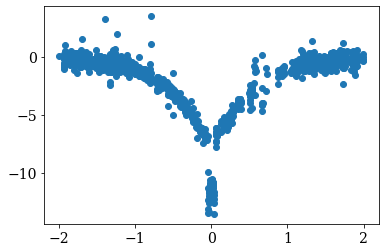

In [422]:
plt.scatter(lc[0, :, 0], lc[0, :, 1])

In [423]:
lc, pis_sort, locs_sort = prepare_lc_mdn(lc, pi.probs.cpu(), normal.loc.cpu())

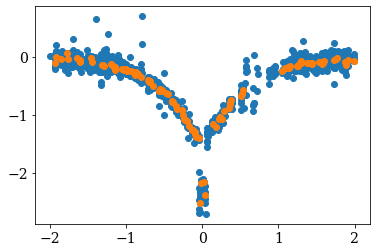

In [426]:
plt.scatter(lc[0, :, 0], lc[0, :, 1]-18)
plt.scatter(data[0, :, 0], data[0, :, 1]/5)

In [474]:
truths[0]

array([ 0.14      , -1.10237291, -0.08301995,  1.50916616, -0.15841034])

In [504]:
param_list

[[0.038071904888080835,
  -2.1555228242543185,
  -0.9100948885606021,
  0.1972805581256193,
  1.5085295357322273,
  -0.06463268228676883],
 [0.14,
  -2.1897674820049158,
  -1.1023729087095586,
  -0.0830199526796178,
  1.5091661555045948,
  -0.15841033617597486],
 array([ 0.14014352, -1.26248174, -0.06388739,  1.50866932, -0.13965118]),
 array([ 0.08556527, -1.1074933 ,  0.16321548,  1.512834  , -0.1137959 ])]

  0%|          | 0/2 [00:00<?, ?it/s]

[ 0.16035597 -1.1381449  -0.06798735  1.5089943 ]
Optimization terminated successfully.
         Current function value: 14025.360250
         Iterations: 116
         Function evaluations: 222
initial chisq:  14449.49061048827
best chisq & (fs, fb):  14025.360249662532 0.7046082447911219 0.26724098829853915
[ 0.10015623 -1.0548594   0.16275391  1.5018314 ]
Optimization terminated successfully.
         Current function value: 14008.422404
         Iterations: 145
         Function evaluations: 253
initial chisq:  16320.473290289632
best chisq & (fs, fb):  14008.422403787616 0.7474675976576108 0.2239104211750913
[0.14, -2.1897674820049158, -1.1023729087095586, -0.0830199526796178, 1.5091661555045948, -0.15841033617597486]
[0.038071904888080835, -2.1555228242543185, -0.9100948885606021, 0.1972805581256193, 1.5085295357322273, -0.06463268228676883]
[ 0.14014352 -1.26248174 -0.06388739  1.50866932 -0.13965118]
[ 0.08556527 -1.1074933   0.16321548  1.512834   -0.1137959 ]


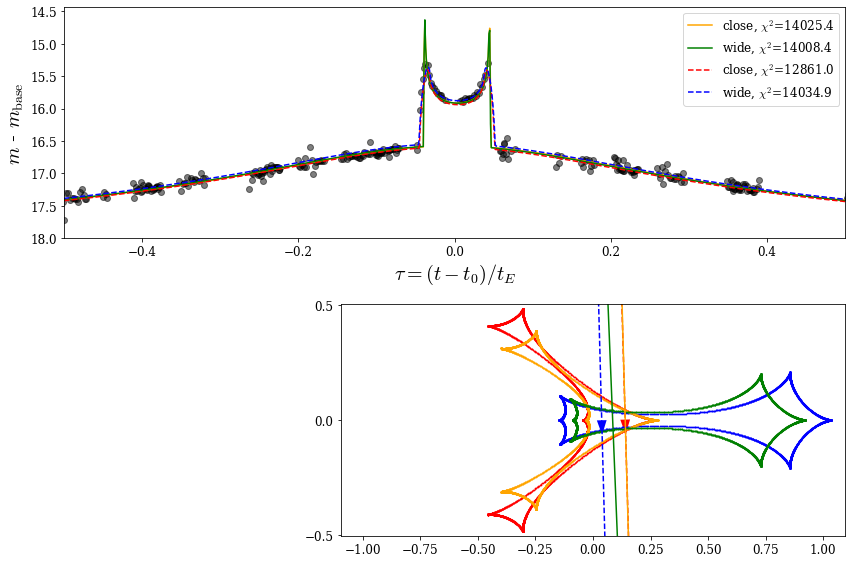

In [517]:
i = 0
verbose = True

fig = plt.figure(1, (12, 8))

ax_lc = plt.subplot2grid(shape=(2, 3), loc=(0, 0), rowspan=1, colspan=3)

plt.xlabel(r'$\tau=(t - t_0)/t_E$', fontsize=20)
plt.ylabel(r'$m$ - $m_{\rm base}$', fontsize=20)


best_parameters = []
colors = ['orange', 'green']
labels = ['close', 'wide']
for index in tqdm(range(2)):
    para_initial = locs_sort[i, index, :-1]
    if verbose:
        print(para_initial)
    para_best, chi2_min, model, warnflag = perform_optimization(lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], para_initial, verbose=verbose)
    chi2_min, fs, fb = compute_chisq(para_best, lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True)
    best_param = np.hstack((chi2_min, warnflag, para_best, np.array([np.log10(fs/(fs+fb))])))
    best_parameters.append(best_param)
    plt.plot(model[0], model[1], label=r'%s, $\chi^2$=%.1f'%(labels[index], chi2_min), color=colors[index])

tru_wide = truths_full[1].tolist()
delta = 10**truths_full[1][2]/(1+10**truths_full[1][2])*(10**truths_full[1][3]-1/10**truths_full[1][3])
tru_wide[0] -= delta * np.cos(tru_wide[-2]*np.pi-3*np.pi/2)

tru_close = truths_full[0].tolist()

chi2_min, fs, fb, model = compute_chisq(np.array(tru_close)[[0, 2, 3, 4]], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True, rho=10**tru_close[1], return_lc=True)
plt.plot(model[0], model[1], label=r'close, $\chi^2$=%.1f'%(chi2_min), color='red', linestyle='dashed')

chi2_min, fs, fb, model = compute_chisq(np.array(tru_wide)[[0, 2, 3, 4]], lc[i, :, 0], lc[i, :, 2], lc[i, :, 3], VBBinaryLensing.VBBinaryLensing(), return_model=True, rho=10**tru_wide[1], return_lc=True)
plt.plot(model[0], model[1], label=r'wide, $\chi^2$=%.1f'%(chi2_min), color='blue', linestyle='dashed')


plt.scatter(lc[0, :, 0], lc[0, :, 1], color='black', alpha=0.5)
plt.xlim(-0.5, 0.5)
plt.ylim(None, 18)
plt.legend(loc='upper right', prop={'size': 12})
plt.gca().invert_yaxis()

param_list = [tru_close, tru_wide, best_parameters[0][2:], best_parameters[1][2:]]
traj_color = ['red', 'blue', 'orange', 'green']
cau_color = traj_color

ax_geo = plt.subplot2grid(shape=(2, 3), loc=(1, 1), rowspan=1, colspan=2)
plt.axis('equal')
plt.xlim(-1, 1)
plt.ylim(-0.3, 0.3)
plt.yticks([-0.5, 0, 0.5])
for j, params in enumerate(param_list):
    if j != None:
        print(params)
        if len(params) == 5:
            u_0, lgq, lgs, alpha_180, lgfs = params
            lgrho = -3
        else:
            u_0, lgrho, lgq, lgs, alpha_180, lgfs = params
        parameters = {
                    't_0': 0,
                    't_E': 1,
                    'u_0': u_0,
                    'rho': 10**lgrho, 
                    'q': 10**lgq, 
                    's': 10**lgs, 
                    'alpha': alpha_180*180,
                }
        modelmm = mm.Model(parameters, coords=None)
        if j == 0 or j == 1:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=True, color=traj_color[j], linestyle='dashed')
        else:
            modelmm.plot_trajectory(t_range=(-2, 2), caustics=False, arrow=False, color=traj_color[j])
        modelmm.plot_caustics(color=cau_color[j], s=3)

# ax = plt.subplot2grid((3, 3), (2, 1), rowspan=1, colspan=2)
# ax.axis('off')
# plt.text(-0.5, 0.7, r'Truth close:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%.2f$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     tru_close[0], tru_close[2], tru_close[3], tru_close[1], tru_close[4]*180, tru_close[5]
# ), fontsize=20, color='red')
# plt.text(0.2, 0.7, r'Truth wide:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%.2f$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     tru_wide[0], tru_wide[2], tru_wide[3], tru_wide[1], tru_wide[4]*180, tru_wide[5]
# ), fontsize=20, color='blue')
# # plt.text(0.2, 0.5, r'Closest Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
# #     param_pred_gap[0], param_pred_gap[2], param_pred_gap[3], param_pred_gap[1], param_pred_gap[4]*180, param_pred_gap[5]
# # ), fontsize=20)
# # plt.text(0.2, 0.1, r'Global Peak:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
# #     param_pred_gap_g[0], param_pred_gap_g[2], param_pred_gap_g[3], param_pred_gap_g[1], param_pred_gap_g[4]*180, param_pred_gap_g[5]
# # ), fontsize=20)
# plt.text(-0.5, 0.3, r'Predicted close:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     best_parameters[0][2:][0], best_parameters[0][2:][1], best_parameters[0][2:][2], -3, best_parameters[0][2:][3]*180, best_parameters[0][2:][4]
# ), fontsize=20, color='orange')
# plt.text(0.2, 0.3, r'Predicted wide:' '\n' r'$u_0=%.3f$, $\lg q=%.3f$, $\lg s=%.3f$,' '\n' r'$\lg\rho=%d$, $\alpha=%.3f\degree$, $\lg f_{\rm S}=%.3f$' % (
#     best_parameters[1][2:][0], best_parameters[1][2:][1], best_parameters[1][2:][2], -3, best_parameters[1][2:][3]*180, best_parameters[1][2:][4]
# ), fontsize=20, color='green')
plt.tight_layout()
plt.show()

In [435]:
best_parameters

[array([ 1.40253602e+04,  0.00000000e+00,  1.40143517e-01, -1.26248174e+00,
        -6.38873896e-02,  1.50866932e+00, -1.39651176e-01]),
 array([ 1.40084224e+04,  0.00000000e+00,  8.55652712e-02, -1.10749330e+00,
         1.63215476e-01,  1.51283400e+00, -1.13795901e-01])]

In [437]:
test_p

[[0.14,
  -2.1897674820049158,
  -1.1023729087095586,
  -0.0830199526796178,
  1.5091661555045948,
  -0.15841033617597486],
 [0.141,
  -2.1555228242543185,
  -0.9100948885606021,
  0.1972805581256193,
  1.5085295357322273,
  -0.06463268228676883]]

[0.62847054 0.21283655 0.03914426 0.02790473]
[[ 0.14       -1.10237291 -0.08301995  1.50916616 -0.15841034]
 [ 0.141      -0.91009489  0.19728056  1.50852954 -0.06463268]]


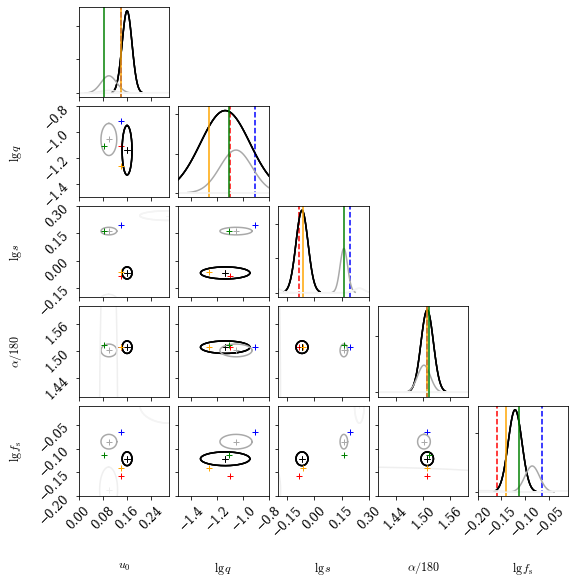

In [471]:
with torch.no_grad():
    pi, normal = model(train_coeffs.float().to(device))
plt.rc('font', size=12)
import plot_triangle
## first sort the gaussians according to the weight ##
i = 0
pi = pi.probs.cpu().numpy()[i]
mu = normal.loc.cpu().numpy()[i]
scale = normal.scale.cpu().numpy()[i]
order = np.argsort(pi)[::-1]
pi = pi[order][:4]
mu = mu[order][:4]
scale = scale[order][:4]
print(pi)
## the ground truth ##
# param_true = [0.34033019, -0.35541759, 0.01886, 1.18859352, -0.8133]
param_true = truths
print(param_true)
#param_true = [0.247, -0.074, 0.227, 291.236/180, -0.094]
param_pred = np.zeros_like(param_true)
norm_fac = np.zeros_like(param_true)

param_best = best_parameters

n_param = len(mu[0])
labels = [r'$u_0$', r'$\lg q$', r'$\lg s$', r'$\alpha/180$', r'$\lg f_{\rm s}$']

param_ranges = [[0, 0.3], [-1.5, -0.8], [-0.2, 0.3], [1.4, 1.6], [-0.2, -0.01]]
for j_gauss in range(len(pi)):
    weight = pi[j_gauss]/pi[0] # normalize the weight by the highest value, so that the color appears better
    cov_mat = np.zeros((n_param, n_param))
    for i in range(len(mu[j_gauss])):
        cov_mat[i, i] = scale[j_gauss, i]**2
    norm_fac += pi[j_gauss] #/np.linalg.det(cov_mat)
    param_pred += mu[j_gauss] * pi[j_gauss] #/np.linalg.det(cov_mat) * mu[j_gauss]
    if j_gauss == 0:
        fig, axes = plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, weight=weight, ground_truth=param_true[0], ground_truth_color='red', ground_truth_ls='dashed')
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight, ground_truth=param_true[1], ground_truth_color='blue', ground_truth_ls='dashed')
    if j_gauss == len(pi)-1:
        param_pred /= norm_fac
        # plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight)
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight, extents=param_ranges, ground_truth=np.array(param_best)[0, 2:], ground_truth_color='orange', ground_truth_ls='-')
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight, extents=param_ranges, ground_truth=np.array(param_best)[1, 2:], ground_truth_color='green', ground_truth_ls='-')
    else:
        plot_triangle.plot_covariance(mu[j_gauss], labels, cov_mat, fig=fig, axes=axes, weight=weight)